We start by assessing used resources in the session.



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Setting up some global variables

In [1]:
SEED = 2

Here I'l add all the libraries needed for the project

In [2]:
from google.colab import files
import pandas as pd
import numpy as np
import io
import nltk
import re
import string
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

## PART 1: DATA UPLOAD, PREPROCESSING AND VISUALIZATION

We start by uploading the data and storing the two datasets from Task 1 and Task 2 into two different Pandas DataFrames.

In [3]:
uploaded = files.upload()

Saving homomex_training.csv to homomex_training.csv
Saving multi_train_labels.csv to multi_train_labels.csv


In [4]:
task1_df = pd.read_csv(io.BytesIO(uploaded['homomex_training.csv']))
task2_df = pd.read_csv(io.BytesIO(uploaded['multi_train_labels.csv']))

We take a look at each DataFrame and it's shape (dimensionality).

In [ ]:
task1_df.shape

(7000, 3)

In [ ]:
task1_df.head()

,index,tweets,label
0,0,"Me quise ligar a una chava ayer y no me pelo, ...",P
1,1,"@papaya_rockera eres un puñal, Papayita.",P
2,2,Magnate ofrece 130 mdd al hombre que conquiste...,P
3,3,Los trolebuses del desgobierno de @EPN son idi...,P
4,4,"En época de Hitler no se decía ""eres gay"" y, s...",P


In [ ]:
task2_df.shape

(862, 6)

In [ ]:
task2_df.head()

,tuit,G,L,B,T,O
0,"—Bueno, pues ya pasó la euforia papá, ahora sí...",1,0,0,0,0
1,"Esos de BTS se me hacen seres asexuales, eunuc...",0,0,0,0,1
2,La partida de skywars que me ha hecho enojar m...,1,0,0,0,0
3,"Se te acabo tu juego maldito joto asqueroso, e...",1,0,0,0,0
4,@Lunaazulada_ Será a los jotitos.??ellos prefi...,1,0,0,0,0


Given that the 3rd class is defined as nan, we'll replace it with a string to avoid future problems (NR -> 'Not Related')

In [ ]:
task1_df['label'].unique()

array(['P', 'NP', nan], dtype=object)

In [5]:
task1_df.fillna('NR', inplace=True)

In [ ]:
task1_df['label'].unique()

array(['P', 'NP', 'NR'], dtype=object)

In [ ]:
task1_df['label'].value_counts()

NP    4360
NR    1778
P      862
Name: label, dtype: int64

In [ ]:
task2_df[['G','L','B','T','O']].apply(pd.Series.value_counts)

,G,L,B,T,O
0,148,790,852,783,798
1,714,72,10,79,64


In [ ]:
int(round(np.mean([len(tweet.split()) for tweet in task1_df['tweets']]),0))

22

In [ ]:
int(round(np.mean([len(tweet.split()) for tweet in task2_df['tuit']]),0))

16

We can clearly observe that the TASK1 dataset (multi-class problem) is way larger than the TASK2 dataset (multi-label problem). We can also quickly check how TASK2 dataset is a subset of TASK2, more specifically, al tweets from TASK2 belong to the LGBT+ phobic class from TASK1:

In [ ]:
task1_df[['tweets']].merge(task2_df[['tuit']], how='inner', left_on='tweets', right_on='tuit').drop_duplicates()

,tweets,tuit
0,"Me quise ligar a una chava ayer y no me pelo, ...","Me quise ligar a una chava ayer y no me pelo, ..."
1,"@papaya_rockera eres un puñal, Papayita.","@papaya_rockera eres un puñal, Papayita."
2,Magnate ofrece 130 mdd al hombre que conquiste...,Magnate ofrece 130 mdd al hombre que conquiste...
3,Los trolebuses del desgobierno de @EPN son idi...,Los trolebuses del desgobierno de @EPN son idi...
4,"En época de Hitler no se decía ""eres gay"" y, s...","En época de Hitler no se decía ""eres gay"" y, s..."
...,...,...
858,(Igual y cachamos a un transformer con este tu...,(Igual y cachamos a un transformer con este tu...
859,Acabé una temporada de RuPaul's Drag Race en 2...,Acabé una temporada de RuPaul's Drag Race en 2...
860,@ArielURosas @nuxsilva Ayuññ. Pos es que me di...,@ArielURosas @nuxsilva Ayuññ. Pos es que me di...
861,"@LaTortilleriaQ si vamos a hacer un vagón ""seg...","@LaTortilleriaQ si vamos a hacer un vagón ""seg..."


In [6]:
def remove_emojis(data):
  # From https://9to5answer.com/removing-emojis-from-a-string-in-python
  emoj = re.compile("["
  u"\U0001F600-\U0001F64F"
  u"\U0001F300-\U0001F5FF"
  u"\U0001F680-\U0001F6FF"
  u"\U0001F1E0-\U0001F1FF"
  u"\U00002500-\U00002BEF" 
  u"\U00002702-\U000027B0"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u"\U00010000-\U0010ffff"
  u"\u2640-\u2642" 
  u"\u2600-\u2B55"
  u"\u200d"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\ufe0f"
  u"\u3030"
  "]+", re.UNICODE)

  return re.sub(emoj, '', data)

def process_tweets(tweet):
    # Load list of stopwords and stemmer (spanish)
    stopwords = nltk.corpus.stopwords.words('spanish')
    stemmer = SnowballStemmer('spanish')
    
    # Tweet converted to lowercase and stripped from starting and ending
    # whitespaces.
    tweet = tweet.lower()
    tweet = tweet.strip()

    # Remove 'RT', hyperlinks and user handles (@)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)

    # Remove emojis
    tweet = remove_emojis(tweet)

    # Remove hashtag # signs  
    tweet = re.sub(r'#', '', tweet)

    # Remove single numeric terms
    tweet = re.sub(r'[0-9]', '', tweet)

    # Remove stopwords from the sentence
    words = tweet.split()
    no_words = [w for w in words if w not in stopwords]
    tweet = " ".join(no_words)

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'—', '', tweet)

    # Token stemming
    tweet = [stemmer.stem(i) for i in word_tokenize(tweet)]
    tweet = " ".join(tweet)

    return tweet



In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
tweets_task1 = task1_df['tweets'].apply(lambda x: process_tweets(x))
tweets_task2 = task2_df['tuit'].apply(lambda x: process_tweets(x))

In [ ]:
tweets_task1

0       quis lig chav ayer pel pregunt si lesbian dio ...
1                                           puñal papayit
2            magnat ofrec mdd hombr conqu hij lesbian url
3       trolebus desgobiern idiot pon valeri dic pit t...
4       epoc hitl dec eres gay y eres jot camp concent...
                              ...                        
6995              igual cach transform tuit mir trist eso
6996            acab tempor rupauls drag rac dias regrets
6997    ayuññ pos dic oph send nerdez trans de “ ahor ...
6998    si vam hac vagon segur inclu hombr gay saqu lench
6999    hmmm entiend reconoc diferent implic luch terc...
Name: tweets, Length: 7000, dtype: object

In [ ]:
tweets_task1[0]

'quis lig chav ayer pel pregunt si lesbian dio cachet laculpaesdegaby'

In [ ]:
tweets_task2

0      buen pues pas eufori pap ahor dim vest blanc a...
1                      bts hac ser asexual eunuc asi rar
2      part skywars hech enoj mas ningun ven ak maric...
3                 acab jueg maldit jot asquer pag pq pag
4                           jotitosell prefier banderill
                             ...                        
857             part avil ching put madr gust puton ojet
858                                       acalambr putit
859    psst sol quier spoiler platic organiz ide cpmx...
860                           ps jot mejor vam cin parec
861      algui bien nen mariquit floj ademas quier acept
Name: tuit, Length: 862, dtype: object

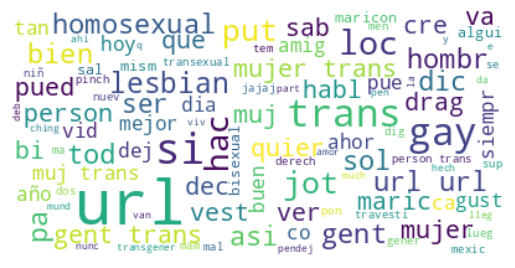

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(tweets_task1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

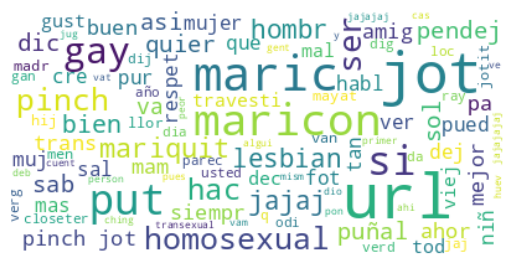

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(tweets_task2))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Now we test two simple models on TASK1 dataset, a Naive Bayes classifier and a linear Support Vector classifier (SVM). In order to implement this algorithms, we'll utilize the TF-Idf method to vectorize our vocabulary. We evaluate the models with the F1-score metric.

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
https://www.kaggle.com/code/redwankarimsony/nlp-101-tweet-sentiment-analysis-preprocessing

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(tweets_task1, task1_df['label'], test_size=0.2, random_state=SEED)

In [ ]:
X_train1.shape

(5600,)

In [ ]:
X_test1.shape

(1400,)

In [ ]:
Tfidf_vect1 = TfidfVectorizer()
Tfidf_vect1.fit(X_train1)

Train_X_Tfidf1 = Tfidf_vect1.transform(X_train1)
Test_X_Tfidf1 = Tfidf_vect1.transform(X_test1)

Naive Bayes model

In [ ]:
naive_bayes1 = MultinomialNB()
naive_bayes1.fit(Train_X_Tfidf1, y_train1) 
predictions_NB1 = naive_bayes1.predict(Test_X_Tfidf1) 

In [ ]:
print(classification_report(predictions_NB1, y_test1))

              precision    recall  f1-score   support

          NP       0.99      0.66      0.80      1299
          NR       0.23      0.89      0.36        96
           P       0.03      0.80      0.05         5

    accuracy                           0.68      1400
   macro avg       0.42      0.78      0.40      1400
weighted avg       0.94      0.68      0.76      1400



SVM model

In [ ]:
SVM1 = SVC(C=1.0, kernel='linear', gamma='auto') 
SVM1.fit(Train_X_Tfidf1, y_train1) 
predictions_SVM1 = SVM1.predict(Test_X_Tfidf1) 

In [ ]:
print(classification_report(predictions_SVM1, y_test1))

              precision    recall  f1-score   support

          NP       0.92      0.85      0.88       941
          NR       0.81      0.84      0.82       361
           P       0.40      0.64      0.49        98

    accuracy                           0.83      1400
   macro avg       0.71      0.78      0.73      1400
weighted avg       0.85      0.83      0.84      1400



Next, we fit the same models for the TASK2. Given that this is a multi-label classification problem, we can utilize the MultiOutputClassifier class from sklearn to define a multi-label classifier through our two algorithms. We evaluate the models with the macro-average F1-score metric.

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-multilabel-svm-classifier-with-scikit-learn.md

In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(tweets_task2, task2_df[['G','L','B','T','O']], test_size=0.15, random_state=SEED)

In [ ]:
X_train2.shape

(732,)

In [ ]:
X_test2.shape

(130,)

In [10]:
Tfidf_vect2 = TfidfVectorizer()
Tfidf_vect2.fit(X_train2)

Train_X_Tfidf2 = Tfidf_vect2.transform(X_train2)
Test_X_Tfidf2 = Tfidf_vect2.transform(X_test2)

Naive Bayes model

In [11]:
naive_bayes2 = MultinomialNB()
multilabel_classifier = MultiOutputClassifier(naive_bayes2, n_jobs=-1)
multilabel_classifier.fit(Train_X_Tfidf2, y_train2) 
predictions_NB2 = multilabel_classifier.predict(Test_X_Tfidf2) 

In [12]:
print("Naive Bayes Accuracy Score:", round(accuracy_score(predictions_NB2, y_test2), 2))

Naive Bayes Accuracy Score: 0.78


In [13]:
print(classification_report(predictions_NB2, y_test2))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       130
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

   micro avg       0.77      0.85      0.81       130
   macro avg       0.20      0.17      0.18       130
weighted avg       1.00      0.85      0.92       130
 samples avg       0.81      0.85      0.82       130



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM model

In [14]:
SVM2 = SVC(C=1.0, kernel='linear', gamma='auto')
multilabel_classifier = MultiOutputClassifier(SVM2, n_jobs=-1)
multilabel_classifier.fit(Train_X_Tfidf2, y_train2)
predictions_SVM2 = multilabel_classifier.predict(Test_X_Tfidf2) 

In [15]:
print("SVM Accuracy Score:", round(accuracy_score(predictions_SVM2, y_test2), 2))

SVM Accuracy Score: 0.87


In [16]:
print(classification_report(predictions_SVM2, y_test2))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       118
           1       0.67      1.00      0.80         6
           2       0.00      0.00      0.00         0
           3       0.54      1.00      0.70         7
           4       0.00      0.00      0.00         0

   micro avg       0.87      0.94      0.90       131
   macro avg       0.44      0.59      0.49       131
weighted avg       0.96      0.94      0.94       131
 samples avg       0.91      0.93      0.91       131



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notas: una hipótesis de por qué da mal resultado de momento en TASK2 es por 2 razones: el tamaño del dataset (pequeño) y que no está balanceado, podría tener menor capacidad predictiva hacia las labels menos visibles. Además parece haber términos con poder predictivo no expresados en su forma original: jotitos, putitos, mariquitas.

Soluciones: data augmentation, data balancing, lemmatization/stemming

In [ ]:
le = LabelEncoder()
le.fit(task1_df['label'])

LabelEncoder()

In [ ]:
list(le.classes_)

['NP', 'NR', 'P']

In [ ]:
!pip install pysentimiento

In [ ]:
from pysentimiento.preprocessing import preprocess_tweet

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(list(map(preprocess_tweet, list(task1_df['tweets']))),
                                                                    list(le.transform(task1_df['label'])), test_size=.2, shuffle=True, random_state=SEED)

In [ ]:
pd.DataFrame({'train_texts': train_texts, 'train_labels': train_labels}).to_csv('./train_task1_robertuito.csv')
pd.DataFrame({'val_texts': val_texts, 'val_labels': val_labels}).to_csv('./val_task1_robertuito.csv')

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(list(map(preprocess_tweet, list(task2_df['tuit']))),
                                                                    task2_df[['G','L','B','T','O']], test_size= 0.15, random_state=SEED)

In [ ]:
train2 = train_labels
train2['train_texts'] = train_texts

val2 = val_labels
val2['val_texts'] = val_texts

train2.to_csv('./train_task2_robertuito.csv')
val2.to_csv('./val_task2_robertuito.csv')

In [ ]:
uploaded = files.upload()

Saving track1_test_no_labels.csv to track1_test_no_labels.csv
Saving track2_test_no_labels.csv to track2_test_no_labels.csv


In [ ]:
pred1_df = pd.read_csv(io.BytesIO(uploaded['track1_test_no_labels.csv']))
pred2_df = pd.read_csv(io.BytesIO(uploaded['track2_test_no_labels.csv']))

In [ ]:
pd.DataFrame(list(map(preprocess_tweet, list(pred1_df['content'])))).to_csv('./pred_task1_robertuito.csv')

In [ ]:
pd.DataFrame(list(map(preprocess_tweet, list(pred2_df['content'])))).to_csv('./pred_task2_robertuito.csv')